This notebook outlines the steps to perform inference using the two stage model on Google Colab.
Make sure GPU is selected as Hardware Accelerator before starting.

In [0]:
import tensorflow as tf

In [2]:
!gdown --id 1ncrxIyUBps_5_iCnYRmRlutCAXrGm4lk -O /content/models.zip

Downloading...
From: https://drive.google.com/uc?id=1ncrxIyUBps_5_iCnYRmRlutCAXrGm4lk
To: /content/models.zip
91.5MB [00:01, 62.4MB/s]


In [3]:
!7z x /content/models.zip -o/content


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 91513627 bytes (88 MiB)

Extracting archive: /content/models.zip
--
Path = /content/models.zip
Type = zip
Physical Size = 91513627

  0%     15% 3 - models/face_detection_model/saved_model.pb                                                    34% 5 - models/face_detection_model/variables/variables.data-00000-of-00001                                                                             53% 9 - models/landmarks_mod

In [4]:
tf.get_logger().setLevel("ERROR")
print("Loading Models...")
face_detection_model = tf.keras.models.load_model(
    "models/face_detection_model"
).signatures["serving_default"]

IMG_SIZE_LANDMARKS = 224
landmarks_model = tf.keras.models.load_model("models/landmarks_model")
print("Finished Loading ;)")

Loading Models...
Finished Loading ;)


In [0]:
def detect_face(img):
  """Detect cat faces in an image 

  Args:
      img: raw bytes of .jpg, .png, .gif, .bmp
  Returns:
      a list of zero or more bounding boxes, i.e. [[x0, y0, x1, y1]]
  """

  # decode image
  img = tf.io.decode_image(img, channels=3, expand_animations=False)
  img = tf.cast(img, tf.uint8)

  # predict using face detection model
  inputs = tf.expand_dims(img, 0)
  outputs = face_detection_model(inputs)
  results = outputs["detections:0"][0]
  bboxes = [bbox[1:5].numpy() for bbox in results]  # x, y, width, height
  bboxes = [
    [bbox[1], bbox[0], bbox[1] + bbox[3], bbox[0] + bbox[2]]  # x0, y0, x1, y1
    for bbox in bboxes
  ]

  return img, bboxes


def detect_landmarks(img, bbox):
  """Detect cat facial landmarks in face ROI 

  Args:
      img: decoded image
      bbox: bounding box
  Returns:
      a list of landmarks, i.e. [left eye x, left eye y, right eye x, right eye y, mouth x, mouth y]
  """

  # crop ROI
  shape = tf.shape(img)[:2]  # [height, width]
  dimensions = tf.reverse(shape, axis=[-1])
  dimensions = tf.cast(dimensions, tf.float32)
  normalized = tf.reshape(bbox, [-1, 2]) / dimensions
  normalized = tf.reshape(normalized, [-1])
  roi = tf.image.crop_and_resize(
    [img],
    [tf.gather(normalized, [1, 0, 3, 2])],  # y0, x0, y1, x1
    [0],
    [IMG_SIZE_LANDMARKS, IMG_SIZE_LANDMARKS],
  )[0]
  roi = (roi / 127.5) - 1  # rescaling to [-1, 1]

  # predict using facial landmarks model
  inputs = tf.expand_dims(roi, 0)
  outputs = landmarks_model.predict(inputs)
  landmarks = outputs[0]

  return landmarks


def project_landmarks(bbox, landmarks):
  """Project landmarks on resized ROI to original image  

  Args:
      bbox: bounding box
      landmarks: a list of landmarks
  Returns:
      a list of projected landmarks
  """

  # project landmarks from IMG_SIZE_LANDMARKS to bbox
  width = bbox[2] - bbox[0]
  height = bbox[3] - bbox[1]

  landmarks = tf.reshape(landmarks, [-1, 2])
  landmarks = landmarks / [IMG_SIZE_LANDMARKS, IMG_SIZE_LANDMARKS] * [width, height]

  # shift landmarks wrt bbox in original image
  landmarks = landmarks + bbox[:2]

  landmarks = tf.reshape(landmarks, [-1])
  return landmarks


def detect_cat(raw):
  """Detect cat facial landmarks in an image 

  Args:
      raw: raw bytes of .jpg, .png, .gif, .bmp
  Returns:
      a list of landmarks on cat faces, i.e. [[left eye x, left eye y, right eye x, right eye y, mouth x, mouth y]]
  """

  img, bboxes = detect_face(raw)
  landmarks = [detect_landmarks(img, bbox) for bbox in bboxes]
  landmarks = [
    project_landmarks(bbox, landmark) for landmark, bbox in zip(landmarks, bboxes)
  ]
  landmarks = [landmark.numpy().tolist() for landmark in landmarks] # convert tf.Tensor into Python list
  return landmarks

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL.ImageDraw import Draw

def chunks(lst, n):
  """Yield successive n-sized chunks from lst."""
  for i in range(0, len(lst), n):
    yield lst[i:i + n]

def show_cat(img, landmarks=[], bboxes=[]):
  img = tf.keras.preprocessing.image.array_to_img(img)
  line_width = int(max(img.size) * 0.01)
  draw = Draw(img)

  for landmark in landmarks:
    for x, y in chunks(landmark, 2):
      draw.ellipse([(x-line_width,y-line_width), (x+line_width,y+line_width)], 'cyan')
    
  for bbox in bboxes:
    draw.rectangle(bbox, outline='yellow', width=line_width)

  plt.imshow(np.asarray(img))
  plt.show()

In [20]:
from google.colab import files
uploaded = files.upload()

Saving _111434467_gettyimages-1143489763.jpg to _111434467_gettyimages-1143489763 (1).jpg


Landmarks:
[438.1048889160156, 200.79412841796875, 538.1331176757812, 187.70623779296875, 496.89825439453125, 257.7446594238281]


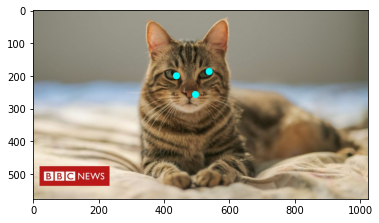

In [21]:
raw = next(iter(uploaded.values()))
landmarks = detect_cat(raw)
print("Landmarks:")
for landmark in landmarks:
  print(landmark)

img = tf.io.decode_image(raw, channels=3, expand_animations=False)
show_cat(img, landmarks=landmarks)